<a href="https://colab.research.google.com/github/pagand/NRC/blob/main/Modeling/NRC_Data_modeling_without_torque_and_thrust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Vessel Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data modeling

In [2]:
# Import libraries
import pandas as pd # for data analsysis
import numpy as np # to handle data in a vectorized manner
import seaborn as sns # for visualization
from sklearn.model_selection import RandomizedSearchCV # for hyperparameters tuning
from sklearn.model_selection import cross_val_score # for cross-validation evaluation
from sklearn.metrics import mean_squared_error # to calculate the RMSE
from joblib import dump # to save a model to disk

Read the dataframe shaped in the previous step

In [4]:
# Save the data frame to a file
df_dummy = pd.read_pickle('/content/drive/MyDrive/df_dummy.pkl')

In [ ]:
df_dummy

,Dati,DEPTH,ENGINE_1_FLOWRATE,ENGINE_1_FLOWRATEA,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWRATE,ENGINE_2_FLOWRATEA,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,...,THRUST_2,TORQUE_1,TORQUE_2,TRACK_MADE_GOOD,WIND_ANGLE,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,Mode1,Trip
101,190830_014200,0.0178,-491.7960,2699.4573,25.6667,433.1773,-488.7158,1346.4690,25.7750,425.8530,...,0.0,36.4661,0.0,246.2233,330.0,9.1800,-78.0717,6.8517,0,0
102,190830_014300,0.0214,-508.4334,2691.1284,25.6117,446.8389,-505.0066,1360.2504,25.7033,439.7944,...,0.0,36.8859,0.0,245.2183,344.0,11.5333,-57.5176,3.7343,0,0
103,190830_014400,0.0224,-526.3786,2676.7666,25.6000,461.7249,-508.8996,1371.9293,25.7000,443.0702,...,0.0,37.5654,0.0,227.5150,0.0,11.8067,-17.2299,2.7061,0,0
149,190830_023000,0.0206,-647.2186,2595.2126,25.7867,561.3356,-619.0157,1460.5645,25.7100,536.0195,...,0.0,297.5184,0.0,40.9200,42.0,7.4267,60.3045,21.1114,0,0
150,190830_023100,0.0215,-748.3470,2514.7930,25.9300,648.2187,-711.7693,1551.8956,25.8250,615.8354,...,0.0,326.9279,0.0,57.4183,34.0,15.6367,71.3253,31.6594,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098603,210930_184800,0.0000,-437.3173,2773.9004,28.1483,384.4809,-548.2856,1400.9686,28.1283,475.5235,...,0.0,190.7087,0.0,0.0000,57.0,11.0867,77.1380,25.0563,1,1
1098604,210930_184900,0.0000,-701.7150,2589.6277,27.7500,610.2312,-770.2502,1605.7662,27.7733,666.4017,...,0.0,301.3788,0.0,0.0000,71.0,9.2133,82.5716,20.2350,0,1
1098605,210930_185000,0.0000,-668.4650,2552.8059,26.7733,582.8834,-775.3284,1607.3137,26.9217,671.4541,...,0.0,289.5499,0.0,0.0000,76.0,12.3350,-65.7418,22.2754,0,1
1098606,210930_185100,0.0000,-681.8159,2528.8425,27.1217,593.1966,-798.6168,1625.3855,27.1767,691.1131,...,0.0,294.3107,0.0,0.0000,46.0,25.2217,-35.8626,37.3497,0,1


### Prepare the input and target variables

Prepare the input features X,y

In [68]:
X = df_dummy.drop(columns={'ENGINE_1_FUEL_CONSUMPTION','ENGINE_2_FUEL_CONSUMPTION'})
X = X.drop(columns={'ENGINE_2_FLOWRATEA','ENGINE_1_FLOWRATE','ENGINE_2_FLOWRATE','ENGINE_1_FLOWRATEA','Dati'})
# feature engineering 
df_dummy = df_dummy.assign(SOGmSTW=lambda x: x.SOG -  x.STW)
df_dummy['pLONGITUDE'] = (df_dummy['LONGITUDE'].shift(periods=-1)).fillna(-123.2733)
df_dummy['pLATITUDE'] = df_dummy['LATITUDE'].shift(periods=-1).fillna(49.3859 )
df_dummy = df_dummy.assign(DISP=lambda x: ((x.LONGITUDE -  x.pLONGITUDE)**2 + (x.LATITUDE-x.pLATITUDE)**2)**(0.5))
df_dummy = df_dummy.assign(PITCH=lambda x: (x.PITCH_1 +  x.PITCH_2)/2)
df_dummy = df_dummy.assign(SPEED=lambda x: (x.SPEED_1 +  x.SPEED_2)/2)
df_dummy = df_dummy.assign(THRUST=lambda x: (x.THRUST_1 +  x.THRUST_2)/2)
df_dummy = df_dummy.assign(TORQUE=lambda x: (x.TORQUE_1 +  x.TORQUE_2)/2)
df_dummy = (df_dummy.assign(OUT=lambda x: (x.ENGINE_1_FUEL_CONSUMPTION +  x.ENGINE_2_FUEL_CONSUMPTION/2/x.DISP*60/10**6)))
#feature selection
y = df_dummy['OUT'].clip(upper=1000)
X = df_dummy[['DEPTH','PITCH','SPEED','STW','WIND_SPEED','WIND_ANGLE','SOG','SOGmSTW','HEADING','DISP']]

# # For using later in Neural networks
# DF = X.copy() 
# DF = DF.join(df_dummy['OUT'].clip(upper=1000))
# DF.to_csv('in_out_NN.csv')
# !cp "/content/in_out_NN.csv" "/content/drive/MyDrive/"

In [6]:
X

,DEPTH,PITCH,SPEED,STW,WIND_SPEED,WIND_ANGLE,SOG,SOGmSTW,HEADING,DISP
101,0.0178,70.435,486.01490,13.7067,9.1800,330.0,13.6783,-0.0284,248.3,0.005536
102,0.0214,70.435,485.04470,12.8117,11.5333,344.0,13.1050,0.2933,245.2,0.005220
103,0.0224,70.435,484.19230,12.8200,11.8067,0.0,12.7167,-0.1033,239.2,0.006325
149,0.0206,70.435,496.29390,14.0983,7.4267,42.0,14.1650,0.0667,215.1,0.004920
150,0.0215,70.435,519.03565,16.9433,15.6367,34.0,17.0267,0.0834,232.2,0.006592
...,...,...,...,...,...,...,...,...,...,...
1098603,0.0000,0.000,501.50930,17.9300,11.0867,57.0,17.2200,-0.7100,235.3,0.006133
1098604,0.0000,0.000,505.86365,15.1700,9.2133,71.0,15.0117,-0.1583,235.4,0.006147
1098605,0.0000,0.000,510.94530,14.4350,12.3350,76.0,14.2433,-0.1917,254.1,0.005814
1098606,0.0000,0.000,509.99980,12.3900,25.2217,46.0,13.6867,1.2967,290.0,0.005255


### Split training and test tests

70 % of data will be used for training (and validation), 30 % for test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

### Scale features (for linear regression)

Feature scaling :
- Range from 0 to 1
- 'Fit' on training data only
- 'Transform' on training and test data

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scaler for X
scaler_x = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

### 1. Linear regression

In [39]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

lin_reg = LinearRegression()
#lin_reg = Lasso(alpha=0.1)
#lin_reg = Ridge(alpha=100)


# Model evaluation by cross-validation
lin_reg_score = cross_val_score(lin_reg, X_train_scaled, y_train, verbose = 2)

# Average Coefficient of determination (R^2) on the validation set
print(f'R^2 Validation: {lin_reg_score.mean()}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
R^2 Validation: 0.3034548668411106


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [40]:
# Fit the model to the training set
lin_reg.fit(X_train_scaled, y_train)

Ridge(alpha=100)

In [41]:
lin_reg.coef_

array([ -14.97084245,   30.59907798,  255.49076437,  415.17835549,
        190.6415872 ,   -1.35868231,  138.38775849, -286.91316274,
       -349.14095482,   80.61768127])

In [42]:
# Compute predictions from the test set
y_pred = lin_reg.predict(X_test_scaled)

In [43]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {lin_reg.score(X_test_scaled, y_test)}')

R^2 Test: 0.30141538993249173


In [44]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 91.809044246281


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


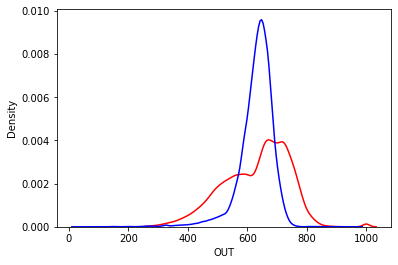

In [23]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("lin_reg.png")

### 2. Polynomial regression

In [45]:
from sklearn.preprocessing import PolynomialFeatures

# Degree 2
poly_features = PolynomialFeatures(degree = 2)

# Returns a transformed version of X with new combinations of features
X_train_scaled_poly = poly_features.fit_transform(X_train_scaled)
X_test_scaled_poly = poly_features.fit_transform(X_test_scaled)

In [46]:
poly_reg = LinearRegression()

# Model evaluation by cross-validation
poly_reg_score = cross_val_score(poly_reg, X_train_scaled_poly, y_train, verbose = 2)

# Average Coefficient of determination (R^2) on the validation set
print(f'R^2 Validation: {poly_reg_score.mean()}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
R^2 Validation: 0.7009360621691856


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


In [47]:
# Fit the model to the training set
poly_reg.fit(X_train_scaled_poly, y_train)

LinearRegression()

In [48]:
# Compute predictions from the test set
y_pred = poly_reg.predict(X_test_scaled_poly)

In [49]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {poly_reg.score(X_test_scaled_poly, y_test)}')

R^2 Test: 0.7010720222844843


In [50]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 60.056392531050456


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


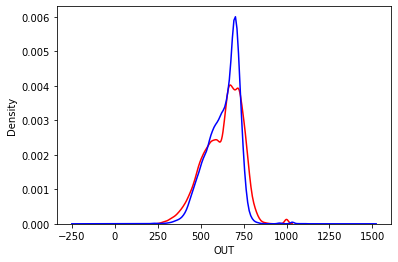

In [51]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("poly_reg.png")

### 3. Decision tree

In [52]:
# Hyperparameter values to feed to the RandomizedSearchCV
param_grid = {'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': np.arange(5, 21, 5), # Maximum number of levels in tree
               'min_samples_split': [5, 10, 20, 40], # Minimum number of samples required to split a node
               'min_samples_leaf': [2, 6, 12, 24], # Minimum number of samples required at each leaf node
               }

In [53]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate a RandomizedSearchCV on a DecisionTreeRegressor model with 100 iterations
tree_reg = RandomizedSearchCV(estimator = DecisionTreeRegressor(), param_distributions = param_grid, n_iter = 10, verbose = 2, n_jobs = -1)

tree_reg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': array([ 5, 10, 15, 20]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 6, 12, 24],
                                        'min_samples_split': [5, 10, 20, 40]},
                   verbose=2)

In [54]:
# Check the best parameters found by RandomizedSearchCV
tree_reg.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 40}

In [55]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {tree_reg.best_score_}')

R^2 Validation: 0.8695842497192832


In [56]:
# Check the features which are considered as most important in making predictions
sorted(dict(zip(X_train.columns, tree_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('STW', 0.5455088371405312),
 ('SPEED', 0.259072710291607),
 ('DISP', 0.07171941386242806),
 ('PITCH', 0.052827573444223716),
 ('WIND_SPEED', 0.023208370211202967),
 ('HEADING', 0.016262244927271366),
 ('SOG', 0.014469039322110447),
 ('DEPTH', 0.008322586718799457),
 ('WIND_ANGLE', 0.004730722086810873),
 ('SOGmSTW', 0.0038785019950147042)]

In [57]:
# Compute predictions from the test set
y_pred = tree_reg.predict(X_test)

In [58]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {tree_reg.score(X_test, y_test)}')

R^2 Test: 0.8749998440897704


In [59]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 38.83570886826823


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


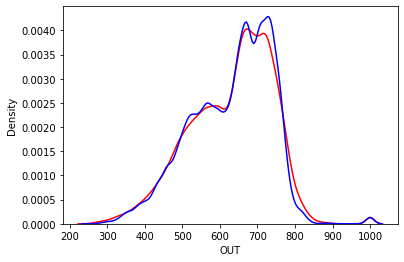

In [60]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("tree_reg.png")

In [ ]:
# Save the model to disk
dump(tree_reg.best_estimator_, 'tree_reg.pkl')

['tree_reg.pkl']

### 4. Random forest

In [81]:
# Hyperparameter values to feed to the RandomizedSearchCV
param_grid = {'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
               'max_depth': np.arange(5, 11, 5), # Maximum number of levels in tree
               #'min_samples_split': [5, 10, 20, 40], # Minimum number of samples required to split a node
              'min_samples_split': [2, 4, 8, 10], # Minimum number of samples required to split a node
               #'min_samples_leaf': [2, 6, 12, 24], # Minimum number of samples required at each leaf node
              'min_samples_leaf': [2, 4, 8, 10], # Minimum number of samples required at each leaf node
               }

In [85]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate a RandomizedSearchCV on a RandomForestRegressor model with 10 iterations
rfor_reg = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_grid, n_iter = 2, verbose = 2, n_jobs = -1)

rfor_reg.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': array([ 5, 10]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8, 10],
                                        'min_samples_split': [2, 4, 8, 10]},
                   verbose=2)

In [86]:
# Check the best parameters found by RandomizedSearchCV
rfor_reg.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [87]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {rfor_reg.best_score_}')

R^2 Validation: 0.7903023850613444


In [88]:
# Check the features which are considered as most important in making predictions
sorted(dict(zip(X_train.columns, rfor_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('STW', 0.6242731372027434),
 ('SPEED', 0.2702565214942021),
 ('DISP', 0.07820854390611685),
 ('PITCH', 0.018577526336758323),
 ('WIND_SPEED', 0.008664349970040224),
 ('SOG', 1.8886221681044024e-05),
 ('HEADING', 1.0348684581335578e-06),
 ('DEPTH', 0.0),
 ('WIND_ANGLE', 0.0),
 ('SOGmSTW', 0.0)]

In [89]:
# Compute predictions from the test set
y_pred = rfor_reg.predict(X_test)

In [90]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {rfor_reg.score(X_test, y_test)}')

R^2 Test: 0.7897489429535931


In [91]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 50.366880490876895


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


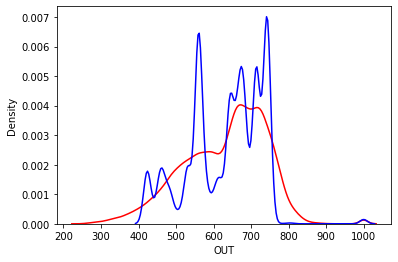

In [92]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("rfor_reg.png")

In [ ]:
# Save the model to disk
dump(rfor_reg.best_estimator_, 'rfor_reg.pkl')

['rfor_reg.pkl']

### 5. AdaBoost

In [ ]:
# Hyperparameter values to feed to the RandomizedSearchCV
param_grid = {"learning_rate"   : [0.01, 0.1, 0.3],
              "loss"            : ['linear', 'square', 'exponential']
             }

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate a RandomizedSearchCV on an AdaBoostRegressor model with 100 iterations
ada_reg = RandomizedSearchCV(AdaBoostRegressor(DecisionTreeRegressor(min_samples_split = 40, min_samples_leaf = 2, max_depth = 40), n_estimators=100), param_distributions = param_grid, n_iter = 100, verbose = 2, n_jobs = -1)

ada_reg.fit(X_train, y_train)

C:\Users\Thierry\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 57.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                    criterion='mse',
                                                                                    max_depth=35,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=6,
                                                                                    min_samples_split=20,
                   

In [ ]:
# Check the best parameters found by RandomizedSearchCV
ada_reg.best_params_

{'loss': 'exponential', 'learning_rate': 0.01}

In [ ]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {ada_reg.best_score_}')

R^2 Validation: 0.8755813429463173


In [ ]:
# Check the features which are considered as most important in making predictions
sorted(dict(zip(X_train.columns, ada_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('Floor area', 0.6552132766437173),
 ('Construction year', 0.10777310455508297),
 ('Floor', 0.10539607055537525),
 ('Gangnam', 0.028410254853605564),
 ('Seocho', 0.018138914198849384),
 ('Songpa', 0.013349857499800834),
 ('Yangcheon', 0.006702875128115294),
 ('Mapo', 0.005962604159016569),
 ('Seongdong', 0.005959497350177519),
 ('Nowon', 0.004617693619477252),
 ('Dongjak', 0.004616283705364693),
 ('Yongsan', 0.004145601197611126),
 ('Gwangjin', 0.004089156586757056),
 ('Eunpyeong', 0.0039858953583672705),
 ('Gangdong', 0.0037820100321949456),
 ('Jungnang', 0.003428234313131193),
 ('Gangseo', 0.003168409491314708),
 ('Dobong', 0.0029967030372235913),
 ('Yeongdeungpo', 0.002967169770677425),
 ('Guro', 0.0025763024475901767),
 ('Jung', 0.002111196510484329),
 ('Geumcheon', 0.0019229165673738768),
 ('Jongno', 0.0017390559507449745),
 ('Dongdaemun', 0.0017088551561595276),
 ('Gangbuk', 0.0013778711713044827),
 ('Seodaemun', 0.0013692141211662666),
 ('Seongbuk', 0.0013507159280677556),
 ('G

In [ ]:
# Compute predictions from the test set
y_pred = ada_reg.predict(X_test)

In [ ]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {ada_reg.score(X_test, y_test)}')

R^2 Test: 0.8763769544514833


In [ ]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 5578.917452079584


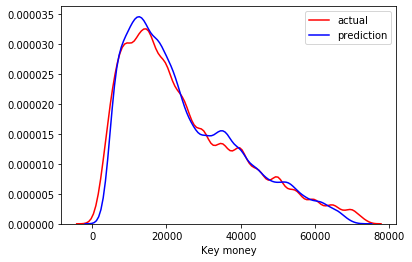

In [ ]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("ada_reg.png")

In [ ]:
# Save the model to disk
dump(ada_reg.best_estimator_, 'ada_reg.pkl')

['ada_reg.pkl']

### 6. Gradient Boosting

In [ ]:
# Hyperparameter values to feed to the RandomizedSearchCV
param_grid = {"learning_rate"   : [0.01, 0.1, 0.3],
             "subsample"        : [0.5, 1.0],
             'max_depth'        : np.arange(5, 21, 5),
             "max_features"     : ['auto', 'sqrt'],
             "min_samples_split": [5, 10, 20, 20],
             "min_samples_leaf" : [2, 6, 12, 24]
             }

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate a RandomizedSearchCV on a GradientBoostingRegressor model with 10 iterations
grad_reg = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions = param_grid, n_iter = 10, verbose = 2, n_jobs = -1)

grad_reg.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 92.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 233.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 342.8min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                          

In [ ]:
# Check the best parameters found by RandomizedSearchCV
grad_reg.best_params_

{'subsample': 1.0,
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 20,
 'learning_rate': 0.1}

In [ ]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {grad_reg.best_score_}')

R^2 Validation: 0.8805040079709251


In [ ]:
# Check the features which are considered as most important in making predictions
sorted(dict(zip(X_train.columns, grad_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('Floor area', 0.5683094062136843),
 ('Floor', 0.17311166498649744),
 ('Construction year', 0.11699036887877863),
 ('Gangnam', 0.027726585558235012),
 ('Seocho', 0.018102830812477544),
 ('Songpa', 0.012631799820373412),
 ('Seongdong', 0.00786253756251729),
 ('Yangcheon', 0.007767428215939422),
 ('Jungnang', 0.0066144038665366615),
 ('Nowon', 0.0066114436338827395),
 ('Eunpyeong', 0.0055429426477037105),
 ('Dobong', 0.005399293276528949),
 ('Guro', 0.004436377441921078),
 ('Dongjak', 0.004378958513642797),
 ('Mapo', 0.004154754065304557),
 ('Geumcheon', 0.003834849688132888),
 ('Gangseo', 0.0036283285934358834),
 ('Gangbuk', 0.00340331903966907),
 ('Gwangjin', 0.0029614132472950585),
 ('Yongsan', 0.002650340648898964),
 ('Gwanak', 0.002420604354997699),
 ('Seongbuk', 0.0023365164571712083),
 ('Gangdong', 0.0019439857883769196),
 ('Dongdaemun', 0.0016268876412279642),
 ('Yeongdeungpo', 0.001568755007882649),
 ('Seodaemun', 0.0014848634313329103),
 ('Jung', 0.001314689352974598),
 ('Jong

In [ ]:
# Compute predictions from the test set
y_pred = grad_reg.predict(X_test)

In [ ]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {grad_reg.score(X_test, y_test)}')

R^2 Test: 0.8805265069180221


In [ ]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 5484.486817059782


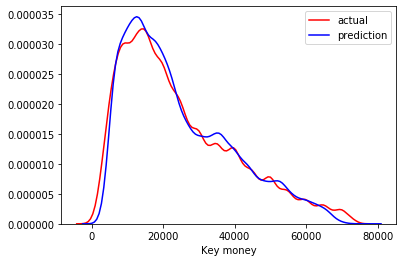

In [ ]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("grad_reg.png")

In [ ]:
# Save the model to disk
dump(grad_reg.best_estimator_, 'grad_reg.pkl')

['grad_reg.pkl']

**bold text**### 7. XGBoost

In [69]:
# Hyperparameter values to feed to the RandomizedSearchCV
param_grid = {"learning_rate"   : [0.01, 0.1, 0.3] ,
             'max_depth'        : np.arange(5, 21, 5),
             "min_child_weight" : [1, 3, 5, 7],
             "gamma"            : [0.0, 0.1, 0.2, 0.3, 0.4],
             "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
             }

In [70]:
from xgboost import XGBRegressor

# Instantiate a RandomizedSearchCV on an XGBRegressor model with 10 iterations
xgb_reg = RandomizedSearchCV(XGBRegressor(), param_distributions = param_grid, n_iter = 10, verbose = 2, n_jobs = -1)

xgb_reg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[05:18:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': array([ 5, 10, 15, 20]),
                                        'min_child_weight': [1, 3, 5, 7]},
                   verbose=2)

In [71]:
# Best parameters
xgb_reg.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': 3}

In [72]:
# Check the cross-validation evaluation metric of the best estimator
print(f'R^2 Validation: {xgb_reg.best_score_}')

R^2 Validation: 0.9041174119985312


In [73]:
# Check the number of times a feature was used to split the data across all trees
sorted(xgb_reg.best_estimator_.get_booster().get_score(importance_type='weight').items(), key=lambda x: x[1], reverse=True)

[('STW', 173989),
 ('DEPTH', 168781),
 ('SPEED', 161285),
 ('WIND_SPEED', 146882),
 ('PITCH', 141019),
 ('HEADING', 138925),
 ('SOGmSTW', 119589),
 ('SOG', 105837),
 ('WIND_ANGLE', 102982),
 ('DISP', 100708)]

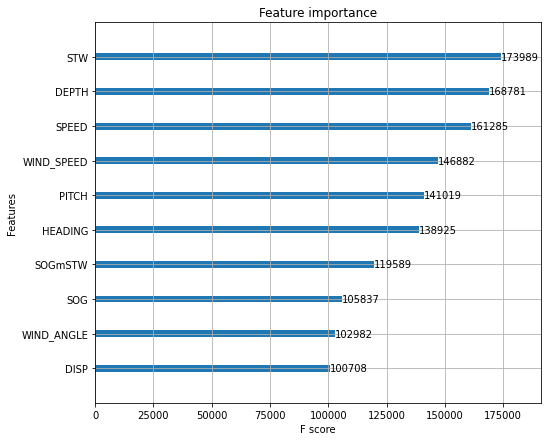

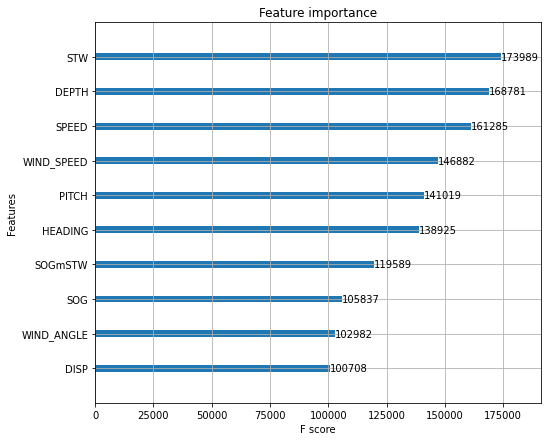

In [75]:
# Plot the same data on a graph
from xgboost import plot_importance
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 7))
plot_importance(xgb_reg.best_estimator_, ax=ax)

In [76]:
# Compute predictions from the test set
y_pred = xgb_reg.predict(X_test)

In [77]:
# Coefficient of determination (R^2) on the test set
print(f'R^2 Test: {xgb_reg.score(X_test, y_test)}')

R^2 Test: 0.9064198649668368


In [79]:
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Test: 33.60220624785744
RMSE Test: 33.60220624785744


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


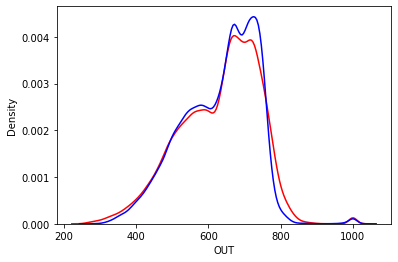

In [80]:
# Visualize the predictions (in blue) against the actual values (in red)
ax1 = sns.distplot(y_test, hist=False, color='r', label='actual')
sns_plot = sns.distplot(y_pred, hist=False, color='b',label='prediction', ax=ax1)

# Save the figure to a file
sns_plot.get_figure().savefig("xgb_reg.png")

In [ ]:
# Save the model to disk
dump(xgb_reg.best_estimator_, 'xgb_reg.pkl')

['xgb_reg.pkl']